#Classes to be implemented


*   TheWorld [DONE]
*   User [DONE]
*   AI_Assistant
    *   Environment
    *   Planner [WIP]
    *   UserModel [WIP]





## Easy Navigation
* [Obj dev area](#dev)
* [Code testing area](#testing)
* [Tutorial starts here](#start)
    * [Initialization](#init)
    * [Task 1: Implement user model](#task1)
    <!--     * [Task 1 part i](#task_11)
        * [Task 1 part ii](#task_12)
        * [Task 1 part iii](#task_13) -->
    * [Task 2: Implement param inference](#task2)
    <!--     * [Case study i: "all coins display tails"](#task_21)
        * [Case study ii: at least "1 coin display tails" ](#task_22)
        * [(Bonus) Case study iii: "Exactly 1 tail"  ](#task_23) -->
    * [Task 3: Implement interaction loop](#task3)
    <!--     * [Task 3 part i](#task_31)
        * [(Optional) Task 3 part ii](#task_32)
        * [Task 3 part iii](#task_33)
            * [Plot by mean/SD value](#task_33_abs)
            * [Plot by RMSE](#task_33_rmse) -->

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import bernoulli, multivariate_normal
from scipy.optimize import minimize
import copy
from tutorialObjs import World, User, Route

# Agent class (WIP) <a class="anchor" id="dev"></a>

In [9]:
class Assistant:
    # MLE infer user params
    # plan assuming MLE
    # delta-dirac
    # analytical closed form posterior of the current user param estimate
    # return param sample
    def __init__(self):
        self.user_model = None
        self.planner = None
        self.env = None
        self.observations = []

    def take_action(self):
        best_action = self.planner.recommend(self.env, self.user_model)
        return best_action

    def observe(self, obs):
        self.observations.append(obs)
        if self.env is None:
            self.env = Env(obs) #,self.user_model)
        self.user_model.update(obs)
        self.env.update(obs)
        self._update(obs)

    def _update(self, obs):
        pass

In [10]:
class Planner:
    def __init__(self):
        pass

    def _plan(self):
        pass

    def _select_best(self):
        pass

    def recommend(self,env,user_model):
        param_sample = user_model.sample()
        all_actions = env.getPossibleActions()
        action = self._select_best(all_actions)
        return action

In [97]:
class Env:
    def __init__(self,world_state,user_model):
        self.world = world_state
        self.user_model = user_model
        self.start = world_state.start
        self.destination = world_state.destination
        self.bin_edges = np.array(world_state.bin_edges)
        self._find_valid_paths()

    def _find_valid_paths(self):
        self.all_roads = list(nx.all_simple_paths(self.world.graph, 
                                                  source=self.start, 
                                                  target=self.destination))
        
        # Generate modes for known task connections
        self.modes_dict = dict()
        self.path_tuples = []
        for road in self.all_roads:
            cur_path = []
            for segment in range(len(road)-1):
                c_begin, c_end = road[segment], road[segment+1]
                cur_path.append((c_begin, c_end))
                if (c_begin,c_end) not in self.modes_dict.keys():
                    # which mode is available?
                    modes_list = world.bin_edges[c_begin][c_end]
                    mode_mask = ['1' in mode for mode in modes_list]
                    mode_ind = [i for i,x in enumerate(mode_mask) if x]
                    self.modes_dict[(c_begin,c_end)] = mode_ind
            self.path_tuples.append(cur_path)
                
    
    # def step(self, action):
    #     pass

    def update(self, obs):
        # infer new params based on obs
        # step 1: find difference + calculate cost difference (also consider choice?)
        pass

    def getCurrentPlayer(self):
        return 1

    def getPossibleActions(self):
        actions = []
        for route in self.path_tuples:
            route_options = []
            for segment in route:
                modes = self.modes_dict[segment]
                for mode in modes:
                    route_options.append()



    def takeAction(self, action):
        raise NotImplementedError()

    def isTerminal(self):
        return self.init_state.path_ai == self.init_state.path_user
        

    def getReward(self):
        # only needed for terminal states
        raise NotImplementedError()

    def __eq__(self, other):
        raise NotImplementedError()

In [51]:
class UserModel(User):
    # implement user cross over
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        mu = self.user_params
        cov = np.eye(3)
        self.param_dist = multivariate_normal(mean=mu,cov=cov)
        

    def update(self, obs):
        if obs.path_ai != obs.path_user:
            # step 1: check what user changed
            ai_advice = [s.get_itinerary() for s in obs.path_ai]
            changes = [s for s in obs.path_user if s.get_itinerary() not in ai_advice]
            for c in changes:
                cost_vec = c.get_costs()

                # step 2: Use Laplace Approx for posterior
                # Debug idea: change init value every time
                init_mean = self.param_dist.mean
                optim = minimize(self._log_posterior, init_mean, args=(cost_vec,), method='BFGS')
                if not optim.success:
                    print("Failed to minimize")
                w_map = optim.x/np.sum(optim.x)
                hessian = np.linalg.inv(optim.hess_inv)

#                 print(w_map,np.any(hessian<0))
                self.param_dist = multivariate_normal(mean=w_map,
                                                      cov=np.abs(hessian))

    def _log_posterior(self,w,a):
        w_mu = self.param_dist.mean
        w_cov = self.param_dist.cov
#         log_prior = (w - w_mu).dot(np.linalg.inv(w_cov)).dot(w - w_mu)
        log_prior = self.param_dist.logpdf(w)
        log_likelihood = w.dot(a) 
        return -1*(log_prior + log_likelihood)
    
    def sample(self):
        return self.param_dist.rvs(size=self.user_params.shape)

## Testing area <a class="anchor" id="testing"></a>

In [28]:
np.random.seed(12345)

N_CITIES = 10
N_MODES = 5

modes_prob = 0.6    # prob of each edge to be existed
modes_cost = [(2*i+1, 1) for i in range(N_MODES)]     # The higher the mode index, more expensive and faster. ## cost = mu + |e| where e~N(0,1) ##
modes_time = [(10*(N_MODES-i), 5) for i in range(N_MODES)]
modes_dist = [(1, 0.2) for i in range(N_MODES)] # same for all for now



world = World(N_CITIES, N_MODES, modes_prob, modes_cost, modes_time, modes_dist)

ai_advice = [(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 1, 3), (1, 5, 4)]
world.step(ai_advice=ai_advice)

<Figure size 700x600 with 0 Axes>

In [52]:
true_b = np.array([1,1,1])/3
b_0 = np.array([.1,.05,.8]) # Debug idea: try different prior vector
truehuman = User(user_param=true_b)
simUser = UserModel(user_param=b_0/np.sum(b_0))

truehuman.observe(world)
simUser.observe(world)

human_action = truehuman.take_action()
world.step(user_action=human_action)

# Debug idea: try different human actions, not just one?
for i in range(5):
#     print(np.linalg.norm(true_b-simUser.param_dist.mean))
#     print(simUser.param_dist.cov)
    simUser.update(world)
#     if i % 10 == 0:
    print("New mean: ", simUser.param_dist.mean)
    print("Pr(true param): ", np.exp(simUser.param_dist.logpdf(true_b)))
    # loglik of true
    print("=====================")
    

New mean:  [0.08078803 0.71832368 0.20088829]
Pr(true param):  0.05660913752978497
New mean:  [0.07906798 0.76510661 0.15582541]
Pr(true param):  0.05512732732006618
New mean:  [0.07894711 0.76839436 0.15265853]
Pr(true param):  0.05501592634132626
New mean:  [0.07893867 0.76862536 0.15243596]
Pr(true param):  0.055008063717241436
New mean:  [0.07893809 0.76864158 0.15242033]
Pr(true param):  0.05500751366135021


# Tutorial starts here <a class="anchor" id="start"></a>

# Task details

We consider there exist 10 cities, each could be connected to others with several different transportation mode. We consider there exist 5 different transportation mode, each could be represented by a graph $G_i=(V, E_i)$ where V are the cities and $E_i$ shows the connections for transportation mode $i$.

The aim of the sequential interaction is to build a path between given starting point and destination and defining a mode of transfer for each route in it.


## Initialization <a class="anchor" id="init"></a>

<Figure size 700x600 with 0 Axes>

Starting point: 7
Destination: 5


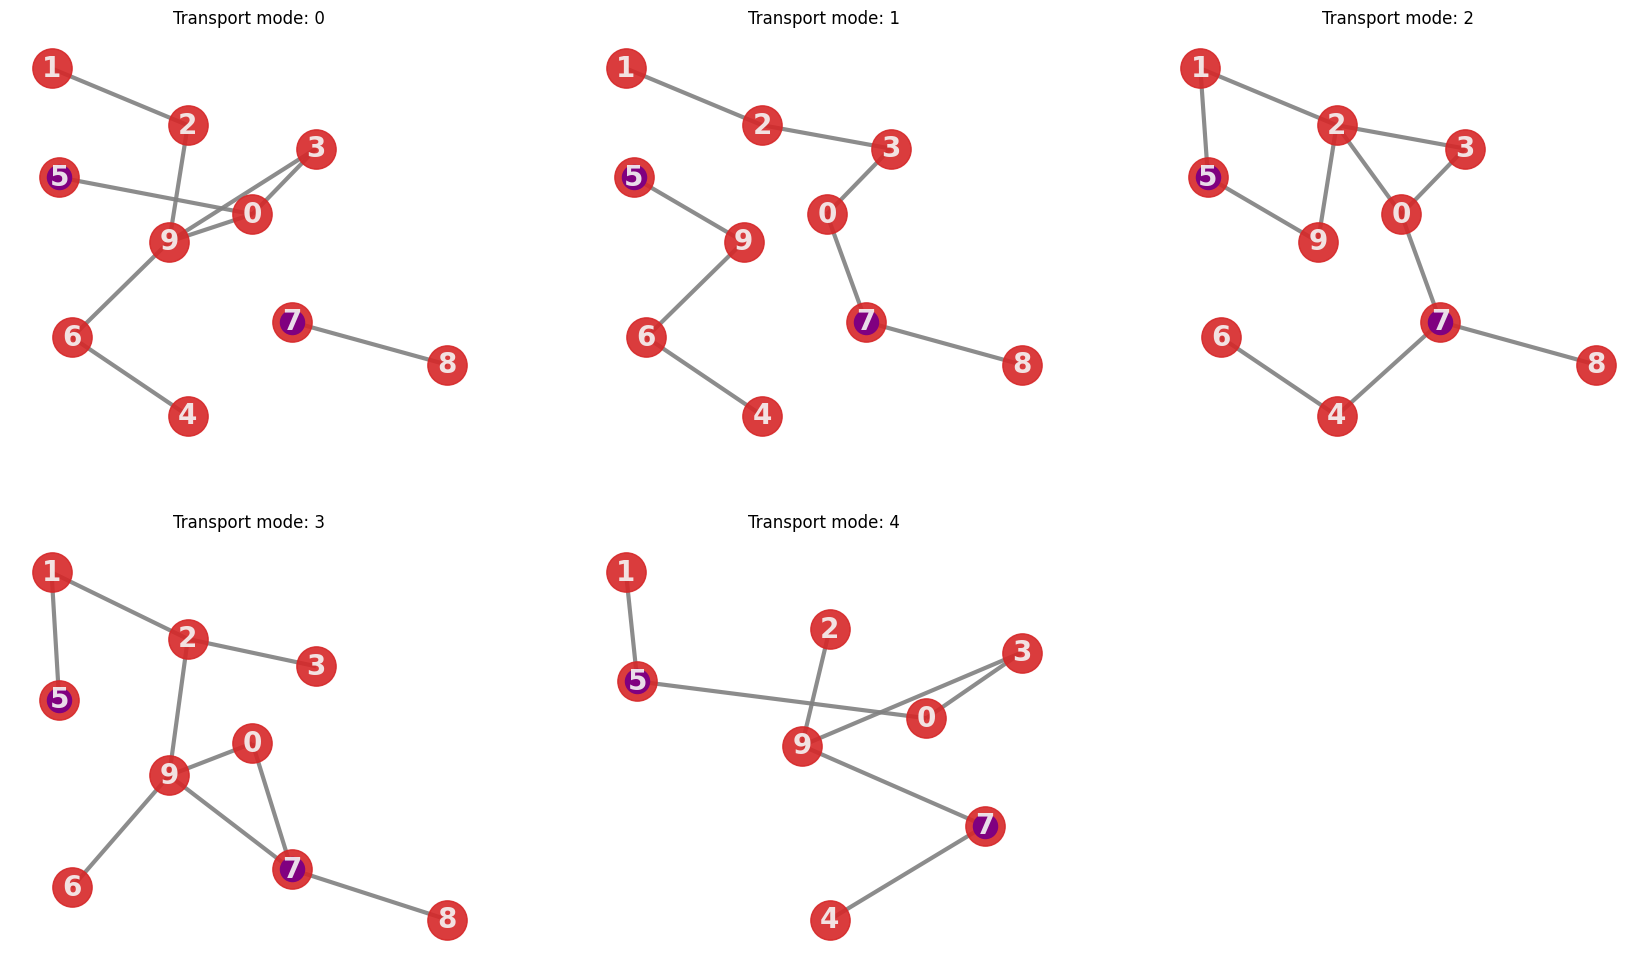

In [3]:
np.random.seed(12345)

N_CITIES = 10
N_MODES = 5

modes_prob = 0.6    # prob of each edge to be existed
modes_cost = [(2*i+1, 1) for i in range(N_MODES)]     # The higher the mode index, more expensive and faster. ## cost = mu + |e| where e~N(0,1) ##
modes_time = [(10*(N_MODES-i), 5) for i in range(N_MODES)]
modes_dist = [(1, 0.2) for i in range(N_MODES)] # same for all for now



world = World(N_CITIES, N_MODES, modes_prob, modes_cost, modes_time, modes_dist)
print("Starting point:", world.start)
print("Destination:", world.destination)
#for i in range(world.n_cities):
    #print(world.edges[i])
# world.display()

In [4]:
ai_advice = [(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 1, 3), (1, 5, 4)]
world.step(ai_advice=ai_advice)

### AI's advice example

In [18]:
ai_advice = [(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 1, 3), (1, 5, 4)]
world.step(ai_advice=ai_advice)

### User's action example

In [13]:
user_action = [(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 9, 2), (9, 5, 2)]
world.step(user_action=user_action)

### Displaying the current path

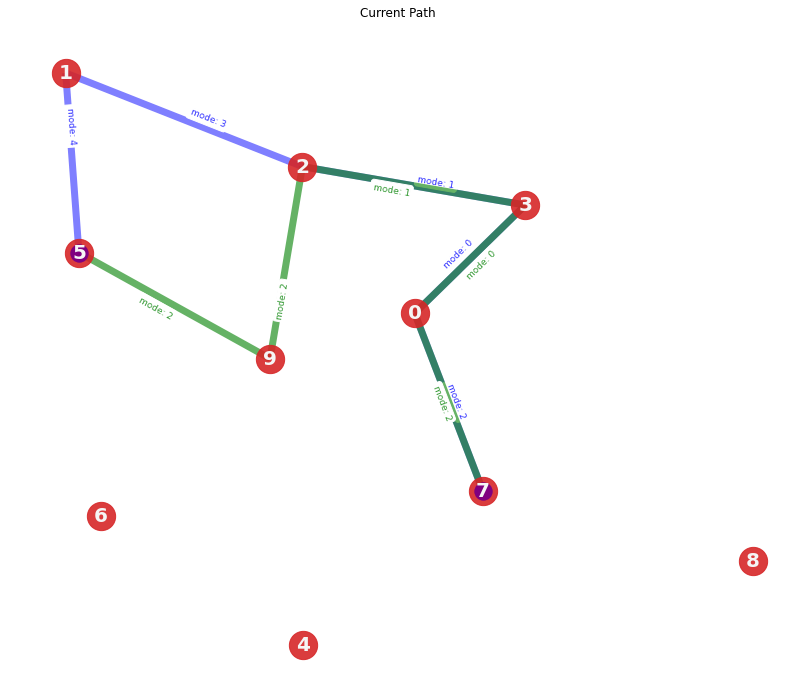

In [14]:
world.display_path()

In [15]:
# In our simplification, human is just a specific instance of a user model
# initiated with a stable/consistent param.
human = UserModel(user_param=np.array([.2,.2,.2]))
# human = User()
human.observe(world)
human.user_policy(ai_advice)

([[(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 1, 3), (1, 5, 2)],
  [(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 1, 3), (1, 5, 3)],
  [(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 1, 3), (1, 5, 4)]],
 array([9.83121887e-01, 1.64096278e-02, 4.68484866e-04]))

In [ ]:
user_action = human.take_action()

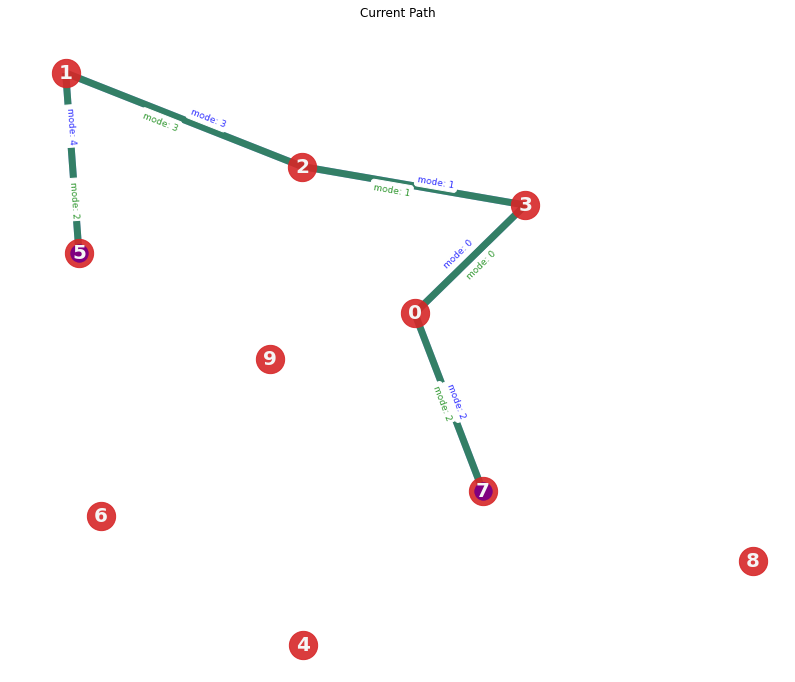

In [ ]:
world.step(user_action=user_action)
world.display_path()

AI assistant

In [ ]:
AI = Assistant()
AI.observe(world)

## Task 1 <a class="anchor" id="task1"></a>

In [ ]:
# Give defined env
# predefined: planner,
# need: task, interaction/loop, user model, inference (implement based on equation)

## Task 2 <a class="anchor" id="task2"></a>

## Task 3 <a class="anchor" id="task3"></a>